## HMMs and Viterbi algorithm for POS tagging.

#### Project Objective.
1) Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words).      
2) Solve the problem of unknown words using at least two techniques.      
3) Compare the tagging accuracy after making these modifications with the Vanilla Viterbi algorithm.    
4) List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were 
incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

In [1]:
# Importing libraries.

import nltk, re
import numpy as np
import pandas as pd
import requests
import pprint, time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
nltk.download('universal_tagset')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package universal_tagset to C:\Users\Vishy
[nltk_data]     Somu\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


### Data Preparation

In [2]:
# Reading the Treebank tagged sentences.
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# Printing first few tagged sentences.

print(nltk_data[:50])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Converting the list of sents to a list of (word, pos tag) tuples.

tagged_words = [tup for sent in nltk_data for tup in sent]
print(len(tagged_words))
tagged_words[:10]

100676


[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET')]

### Exploratory Data Analysis - EDA.

In [5]:
## Finding out how many unique POS tags in the corpus.

tags = [pair[1] for pair in tagged_words]
unique_tags = set(tags)
len(unique_tags)

12

In [6]:
## Finding out the most frequent tag in the corpus.

from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'NOUN': 28867,
         '.': 11715,
         'NUM': 3546,
         'ADJ': 6397,
         'VERB': 13564,
         'DET': 8725,
         'ADP': 9857,
         'CONJ': 2265,
         'X': 6613,
         'ADV': 3171,
         'PRT': 3219,
         'PRON': 2737})

In [7]:
# The most common tags can be seen using the most_common() method of Counter.

tag_counts.most_common(5)

[('NOUN', 28867), ('VERB', 13564), ('.', 11715), ('ADP', 9857), ('DET', 8725)]

In [8]:
# List of POS tags in NLTK.

nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [9]:
# Which tag is most commonly assigned to the word w.

sales = [pair for pair in tagged_words if pair[0].lower() == 'sales']
sales

[('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('Sales', 'NOUN'),
 ('Sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('Sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('Sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('Sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('Sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('Sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('Sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('sales', 'NOUN'),
 ('Sales', 'NOUN'),
 ('sales', 'NOUN'),


In [10]:
# Which tag is most commonly assigned to the word w.

economic = [pair for pair in tagged_words if pair[0].lower() == 'economic']
economic

[('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('Economic', 'NOUN'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('Economic', 'NOUN'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('Economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('Economic', 'NOUN'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('economic', 'ADJ'),
 ('ECONOMIC', 'ADJ'),
 ('econ

In [11]:
## How many words with the tag 'VERB' (verb, past tense) end with 'ed'.

word_as_verb = [pair for pair in tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in word_as_verb if pair[0].endswith('ing')]
print(len(ed_verbs) / len(word_as_verb))
ed_verbs[:20]

0.10852255971689767


[('publishing', 'VERB'),
 ('causing', 'VERB'),
 ('using', 'VERB'),
 ('bring', 'VERB'),
 ('talking', 'VERB'),
 ('having', 'VERB'),
 ('making', 'VERB'),
 ('surviving', 'VERB'),
 ('including', 'VERB'),
 ('including', 'VERB'),
 ('according', 'VERB'),
 ('remaining', 'VERB'),
 ('according', 'VERB'),
 ('declining', 'VERB'),
 ('rising', 'VERB'),
 ('yielding', 'VERB'),
 ('waiving', 'VERB'),
 ('holding', 'VERB'),
 ('holding', 'VERB'),
 ('cutting', 'VERB')]

We see around 11% of the words are VERB ending with 'ing'.

In [12]:
# How many words with the tag 'NOUN' end with 'dent', 'ment', 'tion', 'tage'.

word_as_noun = [pair for pair in tagged_words if pair[1]=='NOUN']
ing_verbs = [pair for pair in word_as_noun if pair[0].endswith(('dent','ment', 'tion', 'tage'))]
print(len(ing_verbs) / len(word_as_noun))
ing_verbs[:20]

0.05456057089410053


[('percentage', 'NOUN'),
 ('attention', 'NOUN'),
 ('information', 'NOUN'),
 ('percentage', 'NOUN'),
 ('regulation', 'NOUN'),
 ('Protection', 'NOUN'),
 ('question', 'NOUN'),
 ('president', 'NOUN'),
 ('fraction', 'NOUN'),
 ('percentage', 'NOUN'),
 ('reinvestment', 'NOUN'),
 ('auction', 'NOUN'),
 ('management', 'NOUN'),
 ('acquisition', 'NOUN'),
 ('transaction', 'NOUN'),
 ('government', 'NOUN'),
 ('government', 'NOUN'),
 ('government', 'NOUN'),
 ('government', 'NOUN'),
 ('Legislation', 'NOUN')]

We see around 5.5% of the words are NOUNs ending with 'dent', 'ment', 'tion', 'tage'.

### Now we will find fraction of words - DET followed by NOUN, ADJ followed by NOUN, PRON followed by VERB.

In [13]:
# What fraction of Determiners DET are followed by a NOUN.

# create a list of all tags (without the words)
tags = [pair[1] for pair in tagged_words]

# create a list of dt tags
dt_tags = [t for t in tags if t == 'DET']

# create a list of (DET, NN) tags
dt_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_tags))
print(len(dt_nn_tags))
print(len(dt_nn_tags) / len(dt_tags))

8725
5569
0.6382808022922636


We see that there is 64% of words where Determiners DET are followed by a NOUN.

In [14]:
# What fraction of adjectives ADJ are followed by a NOUN.

# create a list of all tags (without the words)
tags = [pair[1] for pair in tagged_words]

# create a list of ADJ tags
adj_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, NN) tags
adj_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(adj_tags))
print(len(adj_nn_tags))
print(len(adj_nn_tags) / len(adj_tags))

6397
4474
0.6993903392215101


We see that there is 70% of words where Adjectives ADJ are followed by a NOUN.

In [15]:
# What fraction of PRON are followed by a VERB.

# create a list of all tags (without the words)
tags = [pair[1] for pair in tagged_words]

# create a list of PRON tags
pron_tags = [t for t in tags if t == 'PRON']

# create a list of (PRON, NN) tags
pron_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='PRON' and tags[index+1]=='VERB']

print(len(pron_tags))
print(len(pron_nn_tags))
print(len(pron_nn_tags) / len(pron_tags))

2737
1329
0.4855681402995981


We see that there is 48.5% of words where PRON are followed by a VERB.

### Splitting into train and test.

In [16]:
# random.seed(1234)

## We are using a sample size of 95:5 for training: validation sets as mentioned the requirement. i.e. we keep the 
## validation size small, else the algorithm will need a very high amount of runtime.

POS_train_set, POS_test_set = train_test_split(nltk_data, test_size=0.05, random_state=42)

print("Training DataSet Records -", len(POS_train_set))
print("Testing DataSet Records -", len(POS_test_set))
print("=" * 100)
print("Training Dataset (Tokens, Tags) -\n")
print(POS_train_set[:])

Training DataSet Records - 3718
Testing DataSet Records - 196
Training Dataset (Tokens, Tags) -

[[('Bank', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('England', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('are', 'VERB'), ('traded', 'VERB'), ('*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('.', '.')], [('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('due', 'ADJ'), ('1991-2000', 'NUM'), ('and', 'CONJ'), ('2009', 'NUM'), (',', '.'), ('tentatively', 'ADV'), ('priced', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('a', 'DET'), ('Chemical', 'NOUN'), ('Securities', 'NOUN'), ('Inc.', 'NOUN'), ('group', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('from', 'ADP'), ('6.20', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('1991', 'NUM'), ('to', 'PRT'), ('7.272', 'NUM'), ('%', 'NO

In [17]:
# List of tagged words.

train_POS_tags_words = [i for sent in POS_train_set for i in sent]
len(train_POS_tags_words)

95589

From the above we found that we have 95589 words which are tagged. However it is not necessary that all the taggings are correct.
We will find out, what percentage of it is correctly tagged.

In [18]:
# List of Tagged words in the training set.

train_POS_tags_words[:25]

[('Bank', 'NOUN'),
 ('of', 'ADP'),
 ('New', 'NOUN'),
 ('England', 'NOUN'),
 ("'s", 'PRT'),
 ('shares', 'NOUN'),
 ('are', 'VERB'),
 ('traded', 'VERB'),
 ('*-1', 'X'),
 ('on', 'ADP'),
 ('the', 'DET'),
 ('New', 'NOUN'),
 ('York', 'NOUN'),
 ('Stock', 'NOUN'),
 ('Exchange', 'NOUN'),
 ('.', '.'),
 ('$', '.'),
 ('130', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('of', 'ADP'),
 ('general', 'ADJ'),
 ('obligation', 'NOUN'),
 ('distributable', 'ADJ'),
 ('state', 'NOUN')]

In [19]:
# List of Tokens in training dataset - train_POS_tags_words.

train_data_tokens = [pair[0] for pair in train_POS_tags_words]
train_data_tokens[:25]

['Bank',
 'of',
 'New',
 'England',
 "'s",
 'shares',
 'are',
 'traded',
 '*-1',
 'on',
 'the',
 'New',
 'York',
 'Stock',
 'Exchange',
 '.',
 '$',
 '130',
 'million',
 '*U*',
 'of',
 'general',
 'obligation',
 'distributable',
 'state']

In [20]:
# List of POS tags for tokens in training dataset.

train_data_pos_tags = [pair[1] for pair in train_POS_tags_words]
train_data_pos_tags[:25]

['NOUN',
 'ADP',
 'NOUN',
 'NOUN',
 'PRT',
 'NOUN',
 'VERB',
 'VERB',
 'X',
 'ADP',
 'DET',
 'NOUN',
 'NOUN',
 'NOUN',
 'NOUN',
 '.',
 '.',
 'NUM',
 'NUM',
 'X',
 'ADP',
 'ADJ',
 'NOUN',
 'ADJ',
 'NOUN']

Buidling the set for the tokens & POS tags for tokens in the training dataset.

In [21]:
## This is the set of all Tokens in training dataset.

train_vocab_set = set(train_data_tokens) 
print(len(train_vocab_set))
print("=" * 100)
print(train_vocab_set)

12109
{'unsympathetic', 'Estate', 'Disputado', 'fanciful', 'amicable', '1st', 'tissues', 'dividends', 'Engineers', 'discharge', 'undersecretary', 'consented', 'achieving', 'skyrocketed', '23.72', 'breaks', 'responding', 'assessed', 'thing', 'intellectual-property', 'overpaying', 'Beverly', 'conflict', 'even', 'formerly', 'III', 'Ednie', 'image', 'versus', 'wages', '*T*-230', 'factors', 'Jackson', 'got', 'Everything', 'disseminate', 'manufacturers', 'Oil', 'Gayle', 'before', 'dinner', 'Sundays', 'amending', 'jumped', 'threatened', 'Combo', '*ICH*-4', 'buy-out', 'custom', 'shudders', 'pre-Communist', 'overdone', 'increasing', 'abortion-related', 'Albany', 'assemble', '566.54', 'affordable', 'bribing', '*T*-54', 'Always', 'displays', 'COMPUTERS', 'stuck', 'custom-chip', 'expectation', 'Foreign', 'crisis', 'Rev.', 'merely', 'laurels', 'hither', 'Co', 'similarity', '*T*-77', 'housing-assistance', 'Komatsu', 'Walker', 'yet', 'possibility', 'DSM', 'tidily', 'Signore', 'handful', 'spectacularl

In [22]:
## This is the set of POS tags in training dataset - train_POS_tags_words.

train_pos_tag_set = set([pair[1] for pair in train_POS_tags_words])
print(len(train_pos_tag_set))
print("\n List of Available Tags :\n")
print(train_pos_tag_set)

12

 List of Available Tags :

{'X', 'NUM', 'PRT', 'VERB', 'ADJ', 'CONJ', 'PRON', 'NOUN', 'DET', 'ADV', 'ADP', '.'}


### POS Tagging Algorithm.

Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

#### 1) P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e.

P(w/t) = count(w, t) / count(t).

#### 2) The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (Delicious food, tall person).

Given the universal dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero.

In [23]:
# Computing P(w/t) and storing in [Tags x Vocabulary] matrix.
# Matrix will be of the format ==> [train_vocab_set x train_pos_tag_set]

len_vocab = len(train_vocab_set)
len_pos_tags = len(train_pos_tag_set)

word_given_tag = np.zeros((len_pos_tags, len_vocab))

### Computing Emission Probabilities.

In [24]:
# compute word given tag: Emission Probability.

def word_given_tag(word, tag, train_bag = train_POS_tags_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [25]:
## Checking some examples for Emission probabilities.

# percentage
print("\n", "percentage")
print(word_given_tag('percentage', 'NOUN'))
print(word_given_tag('percentage', 'ADP'))
print(word_given_tag('percentage', 'ADJ'), "\n")

# lost
print("\n", "lost")
print(word_given_tag('lost', 'VERB'))
print(word_given_tag('lost', 'DET'))
print(word_given_tag('lost', 'NOUN'))

# lower
print("\n", "lower")
print(word_given_tag('lower', 'ADJ'))
print(word_given_tag('lower', 'VERB'))


 percentage
(11, 27423)
(0, 9345)
(0, 6077) 


 lost
(15, 12885)
(0, 8284)
(0, 27423)

 lower
(30, 6077)
(0, 12885)


### Computing Transition Probabilities.

In [26]:
# Compute word given tag: Transition Probability.

def t2_given_t1(t2, t1, train_bag = train_POS_tags_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t == t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [27]:
## Checking some examples for Transition probabilities.

print(t2_given_t1(t2='PRON', t1='ADJ'))
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('PRON', 'VERB'))
print(t2_given_t1('ADP', 'ADV'))
print(t2_given_t1('ADJ', 'NOUN'))
print(t2_given_t1('NOUN', 'ADP'))

(4, 6077)
(4234, 6077)
(5302, 8284)
(467, 12885)
(360, 3010)
(337, 27423)
(3007, 9345)


In [28]:
# Please note P(tag|start) is same as P(tag|'.')

print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('PRON', '.'))
print(t2_given_t1('ADJ', '.'))

(1929, 11118)
(984, 11118)
(2481, 11118)
(727, 11118)
(500, 11118)


In [29]:
# Creating t x t transition matrix of tags each column is t2, each row is t1 thus M(i, j) represents P(tj given ti).

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(train_pos_tag_set)):
    for j, t2 in enumerate(list(train_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

# Transition matrix
tags_matrix

array([[7.64818341e-02, 2.70873168e-03, 1.85787126e-01, 2.03632891e-01,
        1.65710635e-02, 1.03569152e-02, 5.60866781e-02, 6.13448061e-02,
        5.51306568e-02, 2.51752716e-02, 1.42925426e-01, 1.63798600e-01],
       [2.06660718e-01, 1.84061855e-01, 2.79512331e-02, 1.75438598e-02,
        3.41956578e-02, 1.33809103e-02, 1.48676778e-03, 3.55337501e-01,
        3.27088917e-03, 2.97353556e-03, 3.47903669e-02, 1.18346713e-01],
       [1.34030730e-02, 5.85158542e-02, 1.63452106e-03, 4.02745992e-01,
        8.63027126e-02, 2.28832942e-03, 1.89604443e-02, 2.42562935e-01,
        1.00359596e-01, 1.01340311e-02, 2.15756781e-02, 4.15168367e-02],
       [2.18005434e-01, 2.28172299e-02, 3.11214589e-02, 1.69188976e-01,
        6.46488145e-02, 5.58789307e-03, 3.62436958e-02, 1.10904150e-01,
        1.33100510e-01, 8.25766400e-02, 9.04928222e-02, 3.53123769e-02],
       [2.13921349e-02, 2.04048045e-02, 1.08606219e-02, 1.23416157e-02,
        6.66447282e-02, 1.69491526e-02, 6.58219506e-04, 6.96

In [30]:
# Checking the Multi-collinearity between POS TAGS. This will help in viewing the data in a better way and understand.

HMM_POS_tags_df = pd.DataFrame(tags_matrix, columns = list(train_pos_tag_set), index=list(train_pos_tag_set))

HMM_POS_tags_df

,X,NUM,PRT,VERB,ADJ,CONJ,PRON,NOUN,DET,ADV,ADP,.
X,0.076482,0.002709,0.185787,0.203633,0.016571,0.010357,0.056087,0.061345,0.055131,0.025175,0.142925,0.163799
NUM,0.206661,0.184062,0.027951,0.017544,0.034196,0.013381,0.001487,0.355338,0.003271,0.002974,0.034790,0.118347
PRT,0.013403,0.058516,0.001635,0.402746,0.086303,0.002288,0.018960,0.242563,0.100360,0.010134,0.021576,0.041517
VERB,0.218005,0.022817,0.031121,0.169189,0.064649,0.005588,0.036244,0.110904,0.133101,0.082577,0.090493,0.035312
ADJ,0.021392,0.020405,0.010861,0.012342,0.066645,0.016949,0.000658,0.696725,0.005101,0.004608,0.078986,0.065328
CONJ,0.007977,0.042234,0.004693,0.153918,0.116847,0.000469,0.058658,0.349132,0.121539,0.055842,0.054435,0.034256
PRON,0.092819,0.007257,0.012223,0.480901,0.074866,0.004966,0.008021,0.211230,0.009549,0.033995,0.022918,0.041253
NOUN,0.029136,0.009627,0.043832,0.147978,0.012289,0.041936,0.004923,0.264632,0.013310,0.016884,0.176275,0.239179
DET,0.045509,0.021970,0.000241,0.038387,0.204973,0.000483,0.003742,0.640029,0.005311,0.012313,0.009054,0.017986
ADV,0.023588,0.030565,0.013621,0.344518,0.130233,0.006312,0.015615,0.030897,0.067110,0.081063,0.119601,0.136877


In [31]:
HMM_POS_tags_df.loc['.', :]

X       0.026623
NUM     0.080500
PRT     0.002339
VERB    0.088505
ADJ     0.044972
CONJ    0.057924
PRON    0.065389
NOUN    0.223152
DET     0.173502
ADV     0.052078
ADP     0.091114
.       0.093812
Name: ., dtype: float32

### Plot Heat Map.

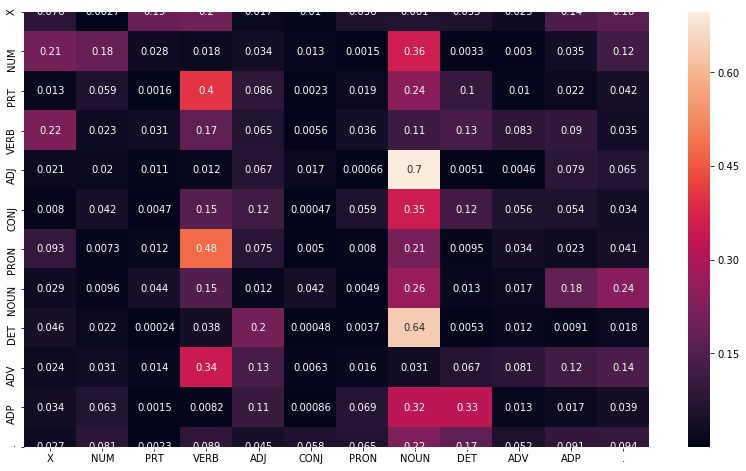

In [32]:
plt.figure(figsize=(14, 8))
sns.heatmap(HMM_POS_tags_df, annot = True)
plt.show()

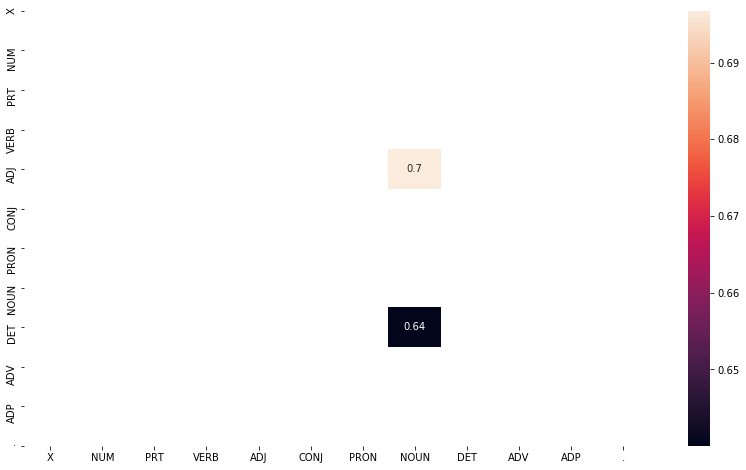

In [33]:
# Now we will find frequent tags.
# Filter the df to get P(t2, t1) > 0.5

tags_frequent = HMM_POS_tags_df[HMM_POS_tags_df > 0.5]
plt.figure(figsize=(14, 8))
sns.heatmap(tags_frequent, annot = True)
plt.show()

### Build Plain Vanilla Viterbi based POS tagger.

In [34]:
def Vanilla_Viterbi(words, train_bag = train_POS_tags_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        p = []  # Initialise list of probability column for a given observation.
        for tag in T:
            if key == 0:
                transition_p = HMM_POS_tags_df.loc['.', tag]
            else:
                transition_p = HMM_POS_tags_df.loc[state[-1], tag]
                
            # Compute emission and state probabilities.
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        state_max = T[p.index(pmax)]  # getting state for which probability is maximum.
        state.append(state_max)
    return list(zip(words, state))

### Evaluating on Test DataSet.

In [35]:
random.seed(1234)

# list of tagged words
test_tagged_words = [tup for sent in POS_test_set for tup in sent]
# test_run_base

# list of untagged words
test_untagged_words = [tup[0] for sent in POS_test_set for tup in sent]

In [36]:
# Tagging the test sentences.

start = time.time()
tagged_seq = Vanilla_Viterbi(test_untagged_words)
end = time.time()
difference = end-start

In [37]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  612.5162844657898
[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'X'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('package'

In [38]:
# Let's check the accuracy of the Vanilla viterbi algorithm.

check = [i for i, j in zip(tagged_seq, test_tagged_words) if i == j]

vanilla_viterbi_accuracy = len(check)/len(tagged_seq)

print("Accuracy of the Vanilla Viterbi Algorithm is -", vanilla_viterbi_accuracy*100)

Accuracy of the Vanilla Viterbi Algorithm is - 91.48810693925694


In [39]:
# Below is the list of incorrectly tagged cases.

incorrect_tags = [[test_tagged_words[i-1],j] for i, j in enumerate(zip(tagged_seq, test_tagged_words)) if j[0]!=j[1]]
print(len(incorrect_tags))
incorrect_tags

433


[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [('the', 'DET'), (('Overseas', 'X'), ('Overseas', 'NOUN'))],
 [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', 'X'), ('pre-1917', 'ADJ'))],
 [('``', '.'), (('Unemployment', 'X'), ('Unemployment', 'NOUN'))],
 [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))],
 [('weekly', 'ADJ'), (('paycheck', 'X'), ('paycheck', 'NOUN'))],
 [('paycheck', 'NOUN'), (('reasonably', 'X'), ('reasonably', 'ADV'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('*-1', 'X'), (('Funded', 'X'), ('Funded', 'VERB'))],
 [('from', 'ADP'), (('Tokio', 'X'), ('Tokio', 'NOUN'))],
 [('medical', 'ADJ'), (('protocols', 'X'), ('protocols', 'NOUN'))],
 [('on', 'ADP'), (('preventative', 'X'), ('preventative', 'ADJ'))],
 [('it', 'PRON'), (('existed', 'X'), ('exi

Lets find out how many Unknown words are present. Unknown words are words present only in TEST DATASET, but not in TRAIN DATASET.

In [40]:
# List of Unknown words.

test_vocab_set = set([t for t in test_untagged_words])

unknown_words = list(test_vocab_set - train_vocab_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 299


Unknown Words : ['noticed', 'Communication', 'Breeden', 'non-core', 'mail', 'emigres', 'shop', 'Mogavero', 'razor-thin', '30s', '*T*-133', 'malignant', 'vested', 'raring', 'mortgaged', 'binders', 'manmade-fiber', 'Muzzling', 'derivatives', 'cross-border', '1953', '94', 'reins', '70-a-share', 'computer-generated', 'slate', 'intrusions', '405', '50.1', 'Piscataway', 'disclose', 'inverse', 'insolvency', 'apologizing', 'crunch', 'side-crash', 'floral', 'compilation', 'fan', 'verge', 'computer-system-design', '5.70', '494.50', 'do-it-yourself', 'Schroder', 'megabytes', '5,699', 'competitions', '*T*-253', 'importer', 'longtime', 'depend', 'container', 'technically', 'longevity', 'reds', 'anti-drug', 'triple', 'Anglia', '6,799', 'spurned', 'actor', 'Walkman', 'brushed', 'inheritor', 'unwanted', 'Gelles', 'Catch-22', '2-8', 'Peninsula', 'protein', 'paycheck', 'exists', 'dreamed', 'topped', 'stock-price', '1955', '84.29', 'Citizens', '1.50', 'sounding', 'competed', '

### Solve the problem of unknown words

### First Method.

If a word is not present in the training vocabulary (unknown word), its emission probability will be ZERO. In that case the state probability will inturn be zero. Thus in cases where the algorithm encounters a word which it has not see previously, we can omit the Emission probability and only consider the Transition probability.

#### We need to modify the algorigthm such that :

#### If word in unknown then  ==>
#### consider only the transition_p (Emission probability ==> 0 )
#### else
#### consider both the emission and transition probability.

### Modification to the Original Vanilla viterbi.

In [41]:
def Vanilla_Viterbi_Unknown_Words(words, train_bag = train_POS_tags_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = HMM_POS_tags_df.loc['.', tag]
            else:
                transition_p = HMM_POS_tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key],tag)[1]
            
            # Modification to the original Vanilla viterbi algorithm to consider unknown words.
            if word not in train_vocab_set:
                state_probability = transition_p ## IF A WORD IS NOT PRESENT IN TRAIN_VOCAB,THEN EMISSION PROB IS ZERO.
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # Getting state for which probability is maximum.
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [42]:
# Tagging the test sentences.

unknown_word_tags = Vanilla_Viterbi_Unknown_Words(test_untagged_words)

# Accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tags, test_tagged_words) if i == j]

modified_viterbi_accuracy = len(unknown_word_check)/len(unknown_word_tags)

print("Accuracy of the Vanilla Viterbi Algorithm after modification is -", modified_viterbi_accuracy*100)

Accuracy of the Vanilla Viterbi Algorithm after modification is - 93.88637703951248


We see that compared to Vanilla Viterbi accuracy (91.48%), we had seen an increase in accuracy after Modification of Vanilla Viterbi (93.88%).      
Approx we see a 2.4% rise in accuracy after Modification of Vanilla Viterbi.

### Lexicon and Rule-Based Models for POS Tagging.

Let's now try training a lexicon (or a unigram) tagger which assigns the most commonly assigned tag to a word.

### Unigram Tagger.

 Here the probability of each word only depends on that word's own probability in the document.

In [43]:
unigram_tagger = nltk.UnigramTagger(POS_train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(POS_test_set)
print("The accuracy of the Unigram Tagger is -", unigram_tagger_accuracy*100)

The accuracy of the Unigram Tagger is - 91.1735797129939


In [44]:
### Building the patterns for tagging.

pattern_1 = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),          # Alpha Numeric
    (r'.*ness$', 'NOUN'),                  # NOUN
    (r'.*\'s$', 'NOUN'),                   # Possessive nouns
    (r'.*s$', 'NOUN'),                     # Plural nouns
    (r'.*', 'NOUN'),                       # NOUN  
    (r'.*ly$', 'ADV'),                     # Adjective
    (r'^(0|([*|-|$].*))','X'),             # Any special character combination
    (r'.*ould$', 'MD'),                    # Modals
    (r'(The|the|A|a|An|an)$', 'DET'),      # DETERMINER 
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'), # Adjective
    (r'.*able$', 'ADJ'),                   # Adjective 
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),     # Any word ending with 'es'/ing'/'ed' is a verb.
    (r'[0-9].?[,\/]?[0-9]*','NUM')         # Numbers 
    ]

Let's now try combining the taggers created above. We saw that the rule-based tagger by itself is quite ineffective since we've only written a handful of rules. However, if we could combine the lexicon and the rule-based tagger, we can potentially create a tagger much better than any of the individual ones.

### Unigram Tagger backed by Rule-based.

In [46]:
# Rule based RegexpTagger.
rule_based_tagger = nltk.RegexpTagger(pattern_1)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(POS_train_set, backoff = rule_based_tagger)

rule_based_unigram_tagger_accuracy = rule_based_unigram_tagger.evaluate(POS_test_set)

print("Accuracy of the Unigram Tagger backed-up by the RegexpTagger is -", rule_based_unigram_tagger_accuracy*100)

Accuracy of the Unigram Tagger backed-up by the RegexpTagger is - 93.7880872813053


### Bigram tagger.

A bigram makes a prediction for a word based on the one before it.

In [47]:
bigram_tagger = nltk.BigramTagger(POS_train_set, backoff = rule_based_unigram_tagger)
bigram_tagger.evaluate(POS_test_set)
bigram_tagger_accuracy = bigram_tagger.evaluate(POS_test_set)
print("Accuracy of the Bigram Tagger backed-up by the rule_based_unigram_tagger is -", bigram_tagger_accuracy*100)

Accuracy of the Bigram Tagger backed-up by the rule_based_unigram_tagger is - 94.12227245920975


### Trigram tagger.

 Trigram makes a prediction for the word based on the two words before that.

In [48]:
trigram_tagger = nltk.TrigramTagger(POS_train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(POS_test_set)
trigram_tagger_accuracy = trigram_tagger.evaluate(POS_test_set)
print("Accuracy of the Trigram Tagger backed-up by the bigram_tagger is -", trigram_tagger_accuracy*100)

Accuracy of the Trigram Tagger backed-up by the bigram_tagger is - 94.04364065264399


### Second Method.

Trigram Tagger backed up by the bigram tagger gives an accuracy of about 94%.
Now we will build a Trigram Tagger backed up by the rule based tagger. 
When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

In [49]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = POS_train_set):
    
    pattern_2 = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),               # Any word ending with 'ed'/ing'/'ed' is a VERB.
    (r'.*ly$', 'ADV'),                               # Adverb ending with 'ly'. 
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),         # Alpha Numeric - ADJ
    (r'.*able$', 'ADJ'),                             # Adjective ending with 'able'. 
    (r'.*ful$', 'ADJ'),                              # Adjective ending with 'ful'. 
    (r'.*ous$', 'ADJ'),                              # Adjective ending with 'ous'. 
    (r'^[aA-zZ].*[0-9]+','NOUN'),                    # Alpha Numeric.
    (r'.*ness$', 'NOUN'),                            # Nouns - words ending with 'ness'.
    (r'.*\'s$', 'NOUN'),                             # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                               # plural nouns.
    (r'.*ers$', 'NOUN'),                             # Nouns ending with 'ers'.
    (r'.*ment$', 'NOUN'),                            # Nouns - words ending with 'ment'.
    (r'.*town$', 'NOUN'),                            # Nouns - words ending with 'town'.
    (r'^(0|([*|-|$].*))','X'),                       # Any special character combination
    (r'.*ould$', 'X'),
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'),                  # Numbers 
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(pattern_2)

    # trigram backed up by the regex tagger.
    trigram_regex_tagger = nltk.TrigramTagger(POS_train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [50]:
def viterbi_backed_by_trigram_tagger(words, train_bag = train_POS_tags_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # Use the trigram tagger backed up by the rule based tagger for unknown words.
    for key, word in enumerate(words):
        if word not in train_vocab_set:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = HMM_POS_tags_df.loc['.', tag]
                else:
                    transition_p = HMM_POS_tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [51]:
# Tagging the test sentences.
viterbi_trigram_tags = viterbi_backed_by_trigram_tagger(test_untagged_words)

# Accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tags, test_tagged_words) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tags)

print("The accuracy of the viterbi_backed_by_trigram_tagger is -", viterbi_trigram_accuracy*100)

The accuracy of the viterbi_backed_by_trigram_tagger is - 96.02909376842933


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

Now we will print the list of all accuracies we calculated so far to find out which method is better.

In [52]:
acccuracy_list = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Modified Vanilla Viterbi', modified_viterbi_accuracy*100], 
                  ['Unigram Tagger', unigram_tagger_accuracy*100],
                  ['Unigram + RegexpTagger', rule_based_unigram_tagger_accuracy*100],
                  ['Bigram Tagger + Unigram_tagger', bigram_tagger_accuracy*100],
                  ['Trigram Tagger + Bigram_tagger', trigram_tagger_accuracy*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

acccuracy_list_df = pd.DataFrame(acccuracy_list, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_list_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_list_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,91.488107
Modified Vanilla Viterbi,93.886377
Unigram Tagger,91.173580
Unigram + RegexpTagger,93.788087
Bigram Tagger + Unigram_tagger,94.122272
Trigram Tagger + Bigram_tagger,94.043641
Viterbi + Trigram_tagger,96.029094


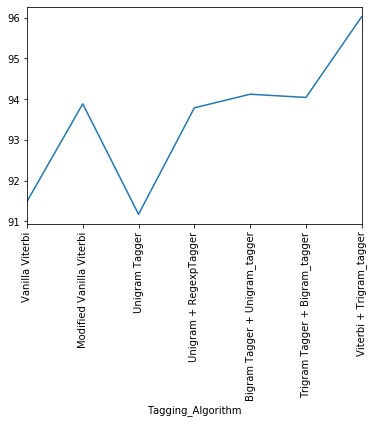

In [53]:
## Plot
acccuracy_list_df.plot.line(rot = 90, legend = False)

Now we will check the tagging accuracy for the sample sentence provided.

In [54]:
test_sample_sent = ['Android is a mobile operating system developed by Google.',
'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
'Show me the cheapest round trips from Dallas to Atlanta',
'I would like to see flights from Denver to Philadelphia.',
'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
'NASA invited social media users to experience the launch of ICESAT-2 Satellite.']

In [55]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

test_sample_token_sents = [word_tokenize(sent) for sent in test_sample_sent]
test_sample_pos_tags = nltk.pos_tag_sents(test_sample_token_sents, tagset = 'universal')
test_sample_pos_tags

[nltk_data] Downloading package punkt to C:\Users\Vishy
[nltk_data]     Somu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Vishy Somu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [56]:
# List of tagged words from the sample test data provided.
test_sample_tag_words = [tup[0] for sent in test_sample_pos_tags for tup in sent]

# List of tokens with their POS tags.
test_sample_token_pos_tag = [tup for sent in test_sample_pos_tags for tup in sent]

In [57]:
## Viewing the list of tagged words.
test_sample_tag_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

In [58]:
## Viewing the list of words & their corresponding POS tags. 
test_sample_token_pos_tag

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADJ'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('se

### 1 ==> Accuracy of Vanilla Viterbi on sample test data.

In [59]:
# Tagging the test sentences.
sample_test_tagged_seq = Vanilla_Viterbi(test_sample_tag_words)

# Let's check the accuracy of the vanilla viterbi algorithm.
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, test_sample_token_pos_tag) if i == j]

vanilla_viterbi_accuracy_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("Accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy_test_data*100)

Accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 75.69060773480662


### 2 ==> Accuracy of Modified Vanilla Viterbi on sample test data.

In [60]:
# Tagging the test sentences.
sample_test_unknown_word_tagged_seq = Vanilla_Viterbi_Unknown_Words(test_sample_tag_words)

# Accuracy.
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, test_sample_token_pos_tag) if i == j]

modified_viterbi_accuracy_test_data = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("Accuracy of Vanilla_Viterbi_Unknown_Words on sample test data is -", modified_viterbi_accuracy_test_data*100)

Accuracy of Vanilla_Viterbi_Unknown_Words on sample test data is - 86.1878453038674


### 3 ==> Accuracy of Viterbi_backed_by_trigram_tagger on sample test data.

In [61]:
# Tagging the test sentences.
sample_test_viterbi_trigram_tagged_seq = viterbi_backed_by_trigram_tagger(test_sample_tag_words)

# Accuracy.
sample_test_viterbi_trigram_check = [i for i, j in zip(sample_test_viterbi_trigram_tagged_seq, test_sample_token_pos_tag) if i == j]

viterbi_trigram_accuracy_test_data = len(sample_test_viterbi_trigram_check)/len(sample_test_viterbi_trigram_tagged_seq)

print("Accuracy of Viterbi_backed_by_trigram_tagger on the sample test data is -", viterbi_trigram_accuracy_test_data*100)

Accuracy of Viterbi_backed_by_trigram_tagger on the sample test data is - 92.81767955801105


### Comparing the accuracies of the 3 algorithm on sample test data.

In [62]:
accuracy_of_three_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_test_data*100], 
                               ['Modified Vanilla Viterbi', modified_viterbi_accuracy_test_data*100], 
                               ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy_test_data*100]]

test_data_accuracy_of_three = pd.DataFrame(accuracy_of_three_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

test_data_accuracy_of_three.set_index('Tagging_Algorithm', drop = True, inplace = True)

test_data_accuracy_of_three

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,75.690608
Modified Vanilla Viterbi,86.187845
Viterbi + Trigram_tagger,92.817680


From the above it is found that Viterbi with Trigram tagger produces the best results with 92.81%.

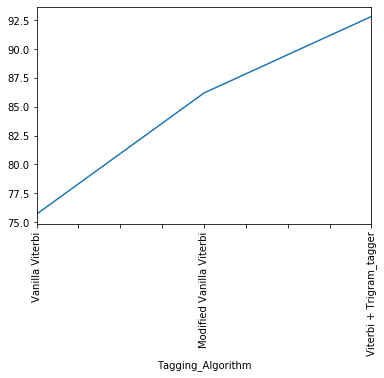

In [63]:
## Plot
test_data_accuracy_of_three.plot.line(rot = 90, legend = False)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [64]:
### Now we will break the sentences into different sets ie; 1 thru 11.

test_sentence_1 = 'Android is a mobile operating system developed by Google.'
test_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
test_sentence_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
test_sentence_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
test_sentence_5 = 'Before entering politics, Donald Trump was a domineering businessman and a television personality.'
test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
test_sentence_7 = 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'
test_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'
test_sentence_9 = 'I would like to see flights from Denver to Philadelphia.'
test_sentence_10 = 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'
test_sentence_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

### Case 1

In [65]:
# test_sentence_1 = 'Android is a mobile operating system developed by Google.'

words_test_sentence_1 = nltk.word_tokenize(test_sentence_1)

# POS tags with Vanilla_Viterbi.
pos_tagged_seq_vanilla_viterbi_1 = Vanilla_Viterbi(words_test_sentence_1)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_seq_vanilla_viterbi_1)

print('\n')
print('='*120)

# POS tags with viterbi_backed up_by_trigram_tagger.
pos_tagged_seq_viterbi_trigram_1 = viterbi_backed_by_trigram_tagger(words_test_sentence_1)
print("Tagging sequence with viterbi_backed_by_trigram_tagger -\n\n", pos_tagged_seq_viterbi_trigram_1)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.')]


Tagging sequence with viterbi_backed_by_trigram_tagger -

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [66]:
cols = ['Vanilla_viterbi_tags', 'Viterbi_trigram_tags_with_corrections']

correction_df_1 = pd.DataFrame(columns = cols)
correction_df_1 = correction_df_1.fillna(0)

correction_df_1.Vanilla_viterbi_tags = [tup for tup in pos_tagged_seq_vanilla_viterbi_1]
correction_df_1.Viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_seq_viterbi_trigram_1]

correction_df_1

,Vanilla_viterbi_tags,Viterbi_trigram_tags_with_corrections
0,"(Android, X)","(Android, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(a, DET)","(a, DET)"
3,"(mobile, ADJ)","(mobile, ADJ)"
4,"(operating, NOUN)","(operating, NOUN)"
5,"(system, NOUN)","(system, NOUN)"
6,"(developed, VERB)","(developed, VERB)"
7,"(by, ADP)","(by, ADP)"
8,"(Google, X)","(Google, NOUN)"
9,"(., .)","(., .)"


### Comments
We see that 2 words had been corrected after using Viterbi + Trigram Tags.      
1) Android      
2) Google

### Case 2

In [67]:
# test_sentence_5 = 'Before entering politics, Donald Trump was a domineering businessman and a television personality.'

words_test_sentence_5 = nltk.word_tokenize(test_sentence_5)

# POS tags with Vanilla_Viterbi.   
pos_tagged_seq_vanilla_viterbi_5 = Vanilla_Viterbi(words_test_sentence_5)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_seq_vanilla_viterbi_5)

print('\n')
print('='*120)

# pos tags with viterbi_backed_by_trigram_tagger.
pos_tagged_seq_viterbi_trigram_5 = viterbi_backed_by_trigram_tagger(words_test_sentence_5)
print("Tagging sequence with viterbi_backed_by_trigram_tagger -\n\n", pos_tagged_seq_viterbi_trigram_5)

Tagging sequence with Vanilla_Viterbi -

 [('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.'), ('Donald', 'NOUN'), ('Trump', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('domineering', 'X'), ('businessman', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('television', 'NOUN'), ('personality', 'X'), ('.', '.')]


Tagging sequence with viterbi_backed_by_trigram_tagger -

 [('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.'), ('Donald', 'NOUN'), ('Trump', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('domineering', 'VERB'), ('businessman', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('television', 'NOUN'), ('personality', 'NOUN'), ('.', '.')]


In [68]:
correction_df_5 = pd.DataFrame(columns = cols)
correction_df_5 = correction_df_5.fillna(0)

correction_df_5.Vanilla_viterbi_tags = [tup for tup in pos_tagged_seq_vanilla_viterbi_5]
correction_df_5.Viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_seq_viterbi_trigram_5]

correction_df_5

,Vanilla_viterbi_tags,Viterbi_trigram_tags_with_corrections
0,"(Before, ADP)","(Before, ADP)"
1,"(entering, VERB)","(entering, VERB)"
2,"(politics, NOUN)","(politics, NOUN)"
3,"(,, .)","(,, .)"
4,"(Donald, NOUN)","(Donald, NOUN)"
5,"(Trump, NOUN)","(Trump, NOUN)"
6,"(was, VERB)","(was, VERB)"
7,"(a, DET)","(a, DET)"
8,"(domineering, X)","(domineering, VERB)"
9,"(businessman, NOUN)","(businessman, NOUN)"


### Comments

We see that 2 words had been corrected after using Viterbi + Trigram Tags.      
1) domineering      
2) personality       

### Case 3

In [69]:
# test_sentence_10 = 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'

words_test_sentence_10 = nltk.word_tokenize(test_sentence_10)

# POS tags with Vanilla_Viterbi.
pos_tagged_seq_vanilla_viterbi_10 = Vanilla_Viterbi(words_test_sentence_10)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_seq_vanilla_viterbi_10)

print('\n')
print('='*120)

# POS tags with viterbi_backed_by_trigram_tagger.
pos_tagged_seq_viterbi_trigram_10 = viterbi_backed_by_trigram_tagger(words_test_sentence_10)
print("Tagging sequence with viterbi_backed_by_trigram_tagger -\n\n", pos_tagged_seq_viterbi_trigram_10)

Tagging sequence with Vanilla_Viterbi -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('price', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('flights', 'NOUN'), ('leaving', 'VERB'), ('Atlanta', 'NOUN'), ('at', 'ADP'), ('about', 'ADP'), ('3', 'NUM'), ('in', 'ADP'), ('the', 'DET'), ('afternoon', 'NOUN'), ('and', 'CONJ'), ('arriving', 'X'), ('in', 'ADP'), ('San', 'NOUN'), ('Francisco', 'NOUN'), ('.', '.')]


Tagging sequence with viterbi_backed_by_trigram_tagger -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('price', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('flights', 'NOUN'), ('leaving', 'VERB'), ('Atlanta', 'NOUN'), ('at', 'ADP'), ('about', 'ADP'), ('3', 'NUM'), ('in', 'ADP'), ('the', 'DET'), ('afternoon', 'NOUN'), ('and', 'CONJ'), ('arriving', 'VERB'), ('in', 'ADP'), ('San', 'NOUN'), ('Francisco', 'NOUN'), ('.', '.')]


In [70]:
correction_df_10 = pd.DataFrame(columns = cols)
correction_df_10 = correction_df_10.fillna(0)

correction_df_10.Vanilla_viterbi_tags = [tup for tup in pos_tagged_seq_vanilla_viterbi_10]
correction_df_10.Viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_seq_viterbi_trigram_10]

correction_df_10

,Vanilla_viterbi_tags,Viterbi_trigram_tags_with_corrections
0,"(Show, NOUN)","(Show, NOUN)"
1,"(me, PRON)","(me, PRON)"
2,"(the, DET)","(the, DET)"
3,"(price, NOUN)","(price, NOUN)"
4,"(of, ADP)","(of, ADP)"
5,"(the, DET)","(the, DET)"
6,"(flights, NOUN)","(flights, NOUN)"
7,"(leaving, VERB)","(leaving, VERB)"
8,"(Atlanta, NOUN)","(Atlanta, NOUN)"
9,"(at, ADP)","(at, ADP)"


### Comments.

We see that 1 word had been corrected after using Viterbi + Trigram Tags.     
1) arriving

#### Default Plain Vanilla Viterbi.

In [71]:
# POS tags with Vanilla_Viterbi.

sample_test_tag_vanilla_viterbi = Vanilla_Viterbi(test_sample_tag_words)
print("Tagging sequence with Vanilla_Viterbi -\n\n", sample_test_tag_vanilla_viterbi)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.'), ('Android', 'X'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'X'), ('worldwide', 'X'), ('on', 'ADP'), ('smartphones', 'X'), ('since', 'ADP'), ('2011', 'X'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'X'), ('.', '.'), ('Google', 'X'), ('and', 'CONJ'), ('Twitter', 'X'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'X'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'X'), ("'s", 'PRT'), ('firehose', 'X'), ('.', '.'), ('Twitter', 'X'), ('is', 'VERB'), ('an', 'DET'), ('online', 'X'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('us

#### Method 1 - POS tags with Modified Vanilla_Viterbi.

In [72]:
sample_test_tag_for_unknown_words = Vanilla_Viterbi_Unknown_Words(test_sample_tag_words)
print("Tagging sequence with viterbi using only transition probability for unknown words -\n\n", 
       sample_test_tag_for_unknown_words)

Tagging sequence with viterbi using only transition probability for unknown words -

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ')

#### Method 2 - POS tags with Viterbi_backed_by_trigram_tagger.

In [73]:
sample_test_tag_for_viterbi_trigram = viterbi_backed_by_trigram_tagger(test_sample_tag_words)
print("Tagging sequence with viterbi_backed_by_trigram_tagger -\n\n", sample_test_tag_for_viterbi_trigram)

Tagging sequence with viterbi_backed_by_trigram_tagger -

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN

### Comparison of all methods.

#### 1. Original tags    
#### 2. Plain Vanilla Viterbi Method.    
#### 3. Modified Vanilla_Viterbi  - METHOD - 1    
#### 4. Viterbi_backed_by_trigram_tagger - METHOD - 2   

In [74]:

list_of_methods = ['Original_tags', 'Vanilla_viterbi', 'Vanilla_Viterbi_Unknown_Words', 'Vanilla_Viterbi_with_trigram_tagger']

tags_comparison_df = pd.DataFrame(columns = list_of_methods)
tags_comparison_df = tags_comparison_df.fillna(0)

# Original tags.
tags_comparison_df.Original_tags = [tup for tup in test_sample_token_pos_tag]

# tags by Plain Vanilla Viterbi.
tags_comparison_df.Vanilla_viterbi = [tup for tup in sample_test_tag_vanilla_viterbi]

# tags by Vanilla_Viterbi for Unknown_Words - METHOD - 1
tags_comparison_df.Vanilla_Viterbi_Unknown_Words = [tup for tup in sample_test_tag_for_unknown_words]

# tags by Viterbi_backed_by_trigram_tagger - METHOD - 2
tags_comparison_df.Vanilla_Viterbi_with_trigram_tagger = [tup for tup in sample_test_tag_for_viterbi_trigram]
                                                                            

tags_comparison_df[tags_comparison_df.Vanilla_viterbi != tags_comparison_df.Vanilla_Viterbi_with_trigram_tagger]

,Original_tags,Vanilla_viterbi,Vanilla_Viterbi_Unknown_Words,Vanilla_Viterbi_with_trigram_tagger
0,"(Android, NOUN)","(Android, X)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, X)","(Google, DET)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, X)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, X)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, X)","(worldwide, NOUN)","(worldwide, NOUN)"
18,"(smartphones, NOUN)","(smartphones, X)","(smartphones, DET)","(smartphones, VERB)"
20,"(2011, NUM)","(2011, X)","(2011, DET)","(2011, NUM)"
25,"(2013, NUM)","(2013, X)","(2013, DET)","(2013, NUM)"
27,"(Google, NOUN)","(Google, X)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, X)","(Twitter, NOUN)","(Twitter, NOUN)"


### Conclusion

#### Vanilla Viterbi

Using Vanilla Viterbi we got tagging accuracy of 91.48 % on test/validation data.     
When tested on sample test data given, we got an accuracy of 75.69%.

#### Method 1 - Modified Vanilla Viterbi + Rule Based.
We used Modified Vanilla Viterbi for unknown words. We got an accuracy of 93.88 % on test/validation data.     
When tested on sample test data, we got an accuracy of 86.18%.         
But it still had words which were incorrectly tagged.

#### Method 2 - Viterbi algorithm + Trigram tagger backed by Regex tagger.
Here we used the Viterbi algorithm + Trigram tagger which was inturn backed up by the rule based regex tagger.   
We got an accuracy of 96 % on test/Validation data. When tested on sample test data, we got an accuracy of 92.81% which is 
much better than accuracy of other methods.

### So we conclude that it is better to use Method - 2 ie; Viterbi Algorithm + Trigram tagger which was inturn backed up by rule based regex tagger.